In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from src.load_data import *
from src.graphs import *
from src.statistical_tests import *
from src.utils import *

In [2]:
df = get_data(format_type='all', remove_minus_ones = False)


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


### Split data:

In [3]:
df = df_main.copy(deep = True)
df.head()

NameError: name 'df_main' is not defined

In [4]:
# Start off with some graphs to better understand percentiles!
def graph_percentile(df, 
                     column = 'total_clearence_in_respect_to_beginning',
                     increment = 20):
    '''
    graph percentile for each visit_nr to better understand percentiles
    '''
    def get_percentile_list_for_nr_visit_df(quantile):
        quantile_list = [float(df.loc[df['visit_number'] == visit_nr][column].quantile(quantile/100)) for visit_nr in range(0,15)]
        return quantile_list

    range_list = [i for i in range(0, 101, increment)]
    print(range_list)
    data = {f'quantile {quantile}' : get_percentile_list_for_nr_visit_df(quantile) for quantile in range_list}

    plt.figure(figsize=(20,10))
    for name, data in data.items():
        plt.plot(data, label = name)
    plt.legend()
    # return data
    

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


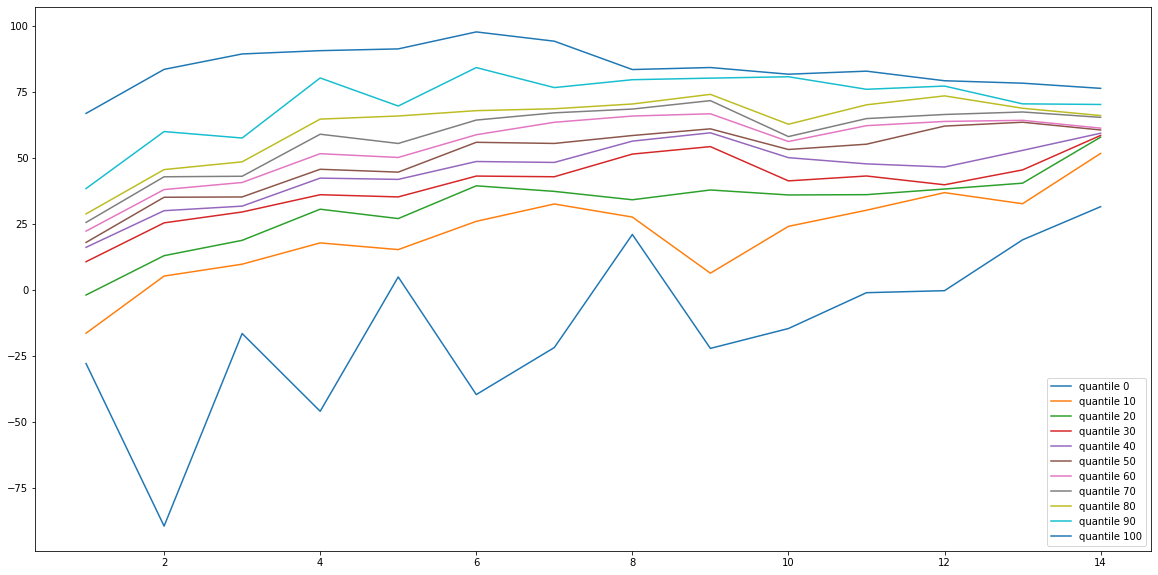

In [5]:
graph_percentile(df, increment = 10)

[0, 25, 50, 75, 100]


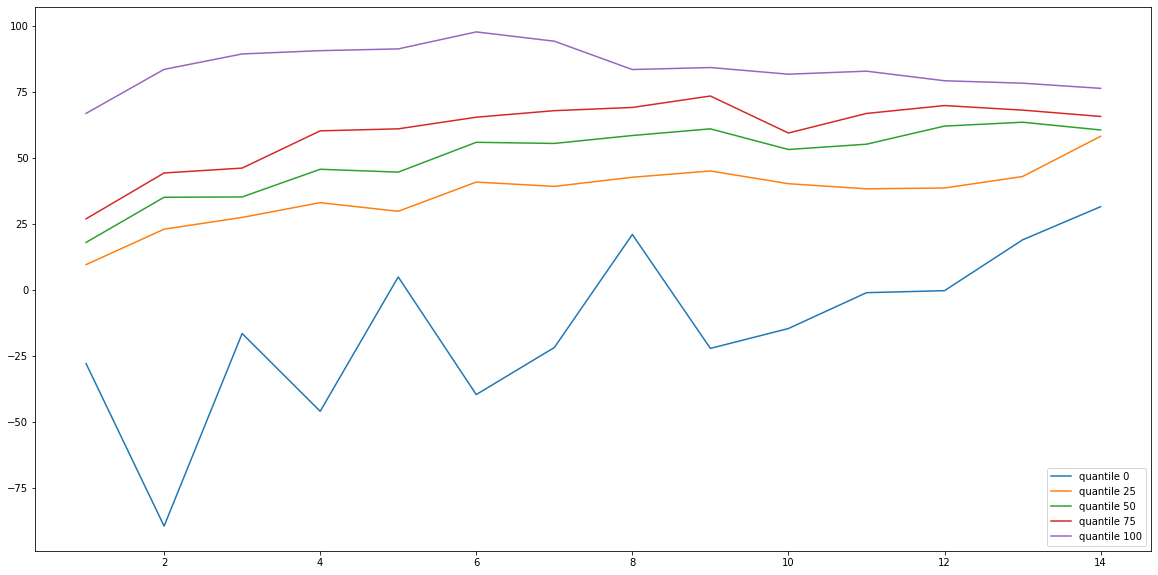

In [6]:
graph_percentile(df, increment = 25)

In [7]:
column = 'total_clearence_in_respect_to_beginning'
split_numbers = [0,50,100]
split_groups = 2

quantile_list = [float(df[column].quantile(i/100)) for i in split_numbers]
def get_sub_df(pct1, pct2):
    return df.loc[(df[column] >= pct1) & (df[column] <= pct2)]
    
if split_groups == 3 :
    return_dict =  {
        f'slow_responders ({split_numbers[0]} - {split_numbers[1]} percentile)' : get_sub_df(quantile_list[0], quantile_list[1]),
        f'medium_responders ({split_numbers[1]} - {split_numbers[2]} percentile)' : get_sub_df(quantile_list[1], quantile_list[2]),
        f'fast_responders ({split_numbers[2]} - {split_numbers[3]} percentile)' : get_sub_df(quantile_list[2], quantile_list[3]),
    }

elif split_groups == 2:
    return_dict =  {
        f'slow_responders ({split_numbers[0]} - {split_numbers[1]} percentile)' : get_sub_df(quantile_list[0], quantile_list[1]),
        f'fast_responders ({split_numbers[1]} - {split_numbers[2]} percentile)' : get_sub_df(quantile_list[1], quantile_list[2]),
    }

In [8]:
def  divide_n_plot_patients(format_type : str = 'all',
                            remove_minus_ones = False,
                            column = 'total_clearence_in_respect_to_beginning',
                            split_groups = 2,
                            split_numbers = [0,50,100],
                            visit_nr = 5):
    '''
    This functions divides patients into groups, based on how well they responded to the treatment.
    
    Parameters
    ---------------------------------------------------
    format_type: str
        'all' - no changes to data (default)
        'moved_to_0' - move visit_nr of people who didn't have first few visits (Bad practice. Used due to lack of data)
        'all_without_0s' - remove visitors who didn't have the first visit
        

    remove_minus_ones: bool (False default)
        Remove visits that didn't have total_clearence_in_between_visits (so they had -1 in place of total_clearence_in_between_visits)
    
    column: str
    (This variable has to agree with whether remove_minus_ones was called!)
        'total_clearence_in_respect_to_beginning' (default)
        'total_clearence_in_between_visits'
        

    split_groups: int (either 2 or 3)
        2 - split into slow and fast responders (default)
        3 - split into slow, medium and fast responders 

    split_numbers: list[int]
    Has to agree with split_groups (len(list) = split_groups + 1)
    Examples:
        [0,33,66,100] - for 3-group split
        [0,50,100] - for 2-group split
        [0,75,100] - for 2-group split

    visit_nr: int
        Based on which visit number should we split? (aka, fast-responders are people in over 80th percentile after visit 5)

    Returns
    ---------------------------------------------------    
    return dict{'responder_type': pd.DataFrame}
        pd.DataFrame has visits data within it
        Each row represents one medical visit which aim was to heal the birth scar (port-wine stain)
        Each row has a data on:
            * surname - surname of patient & nr of patient (ex. 4.Ball)
            * total_clearence_in_between_visits - How sucessful was healing compared to previous visit (in %)
            * total_clearence_in_respect_to_beginning - How sucessful was healing compared to very beginning, before any visits  (in %)
            * time - How many days passed since last visit 
            * visir_number - visit number

    '''
    def get_sub_df(pct1, pct2):
        surnames = list(single_visit_df.loc[(single_visit_df[column] >= pct1) & (single_visit_df[column] <= pct2)]['surname'])
        # print(surnames)
        return df.loc[df['surname'].isin(surnames)]

    # Check all variables
    if type(remove_minus_ones) != bool: raise Exception()
    if format_type not in ['all', 'moved_to_0', 'all_without_0s']: raise Exception()
    if column not in ['total_clearence_in_respect_to_beginning', 'total_clearence_in_between_visits'] : raise Exception()
    if len(split_numbers) not in [3,4]: raise Exception()
    if split_groups not in [2,3]: raise Exception()
    # Run checks - some pair of variables shouldnt be set together
    if remove_minus_ones == True and column == 'total_clearence_in_respect_to_beginning' : raise Exception()
    if remove_minus_ones == False and column == 'total_clearence_in_between_visits' : raise Exception()
    if split_groups!= len(split_numbers) - 1: raise Exception()

    df = get_data(format_type=format_type, remove_minus_ones = remove_minus_ones)
    single_visit_df = df.loc[df['visit_number'] == visit_nr]
    quantile_list = [float(single_visit_df[column].quantile(i/100)) for i in split_numbers]
    # print('thresholds(appropriate quantiles)', quantile_list)
        
    if split_groups == 3 :
        data_dict =  {
            f'slow_responders ({split_numbers[0]} - {split_numbers[1]} percentile)' : get_sub_df(quantile_list[0], quantile_list[1]),
            f'medium_responders ({split_numbers[1]} - {split_numbers[2]} percentile)' : get_sub_df(quantile_list[1], quantile_list[2]),
            f'fast_responders ({split_numbers[2]} - {split_numbers[3]} percentile)' : get_sub_df(quantile_list[2], quantile_list[3]),
        }

    elif split_groups == 2:
        data_dict =  {
            f'slow_responders ({split_numbers[0]} - {split_numbers[1]} percentile)' : get_sub_df(quantile_list[0], quantile_list[1]),
            f'fast_responders ({split_numbers[1]} - {split_numbers[2]} percentile)' : get_sub_df(quantile_list[1], quantile_list[2]),
        }
    else : 
        raise Exception()

    plt.figure(figsize=(20,10))
    for i, (name, df) in enumerate(data_dict.items()):
        agg_column_graph(df, label = f"{name}  [{round(quantile_list[i+1])} GCE]", column = 'total_clearence_in_respect_to_beginning', title = '', cut_last_x_visits = 27)
    plt.title(f'Based on total clearence of {visit_nr}th visit')

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


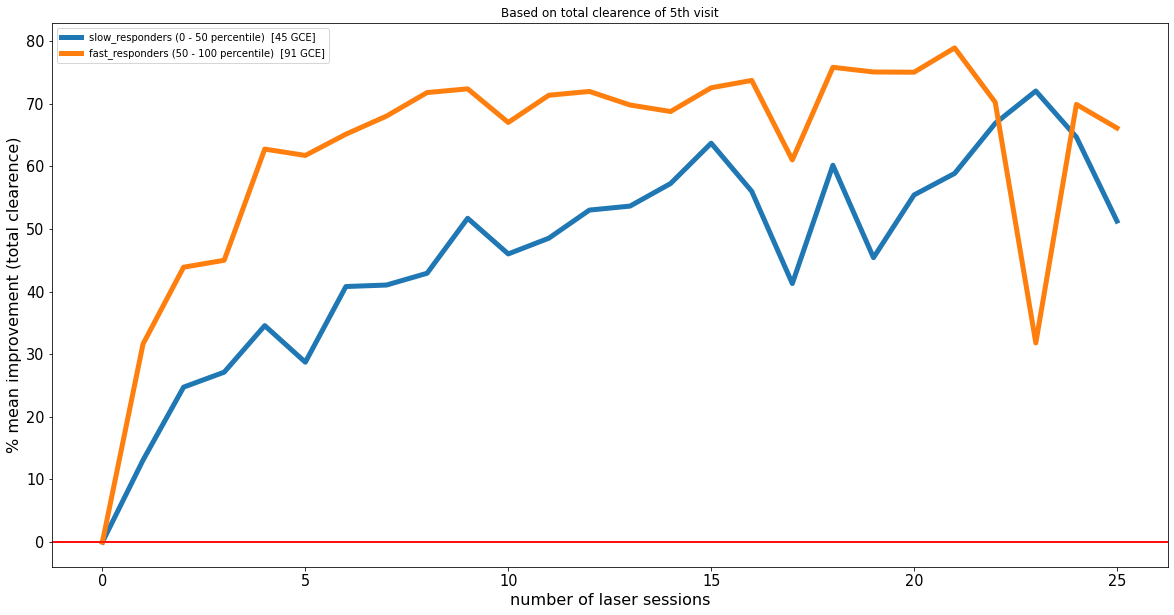

In [9]:
divide_n_plot_patients(split_groups = 2, split_numbers = [0,50,100], visit_nr = 5)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


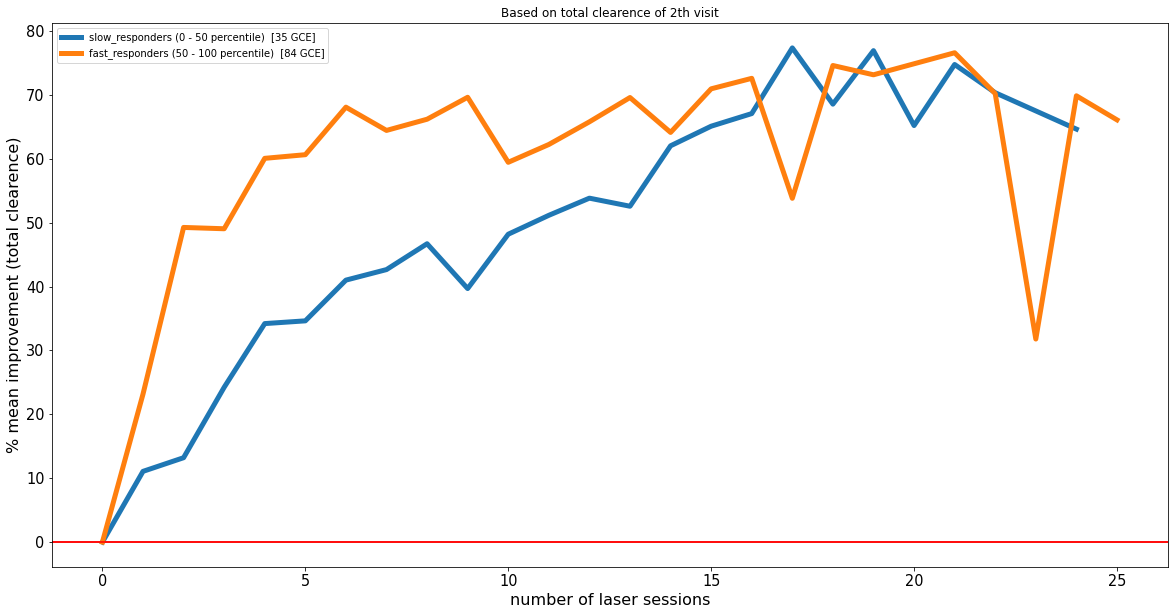

In [10]:
divide_n_plot_patients(visit_nr = 2)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


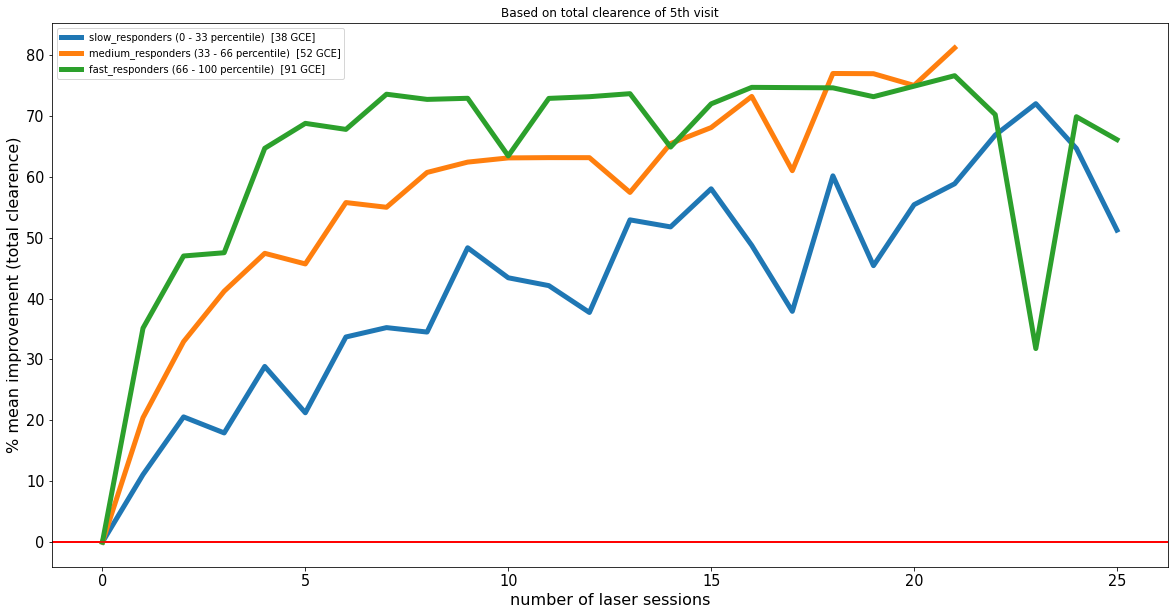

In [11]:
divide_n_plot_patients(visit_nr = 5, split_numbers = [0,33,66,100], split_groups = 3)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


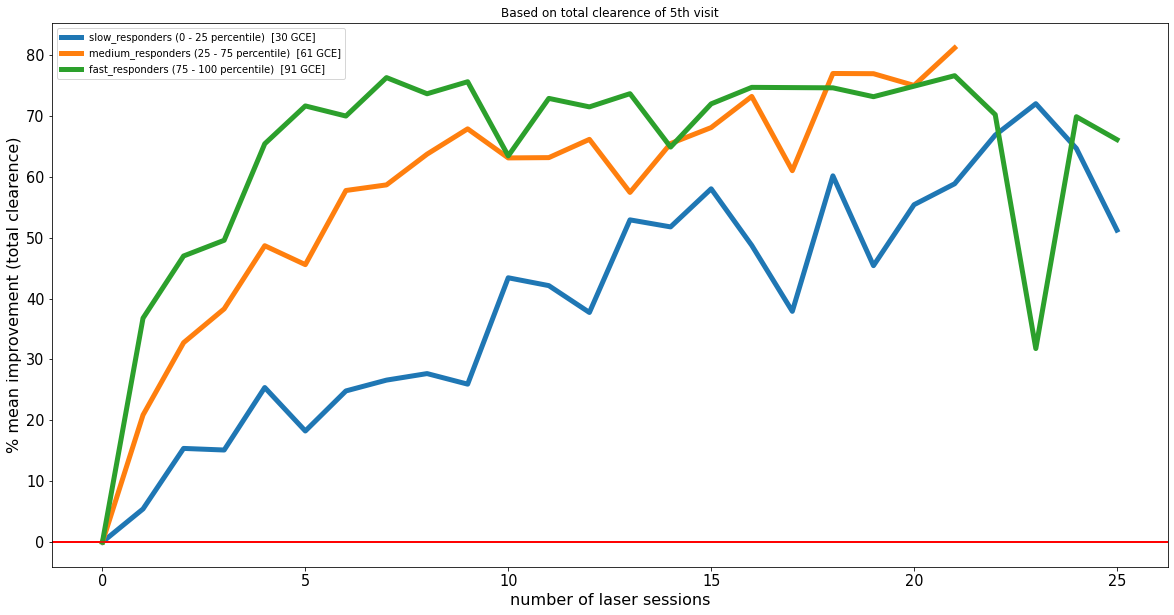

In [12]:
divide_n_plot_patients(visit_nr = 5, split_numbers = [0,25,75,100], split_groups = 3)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]


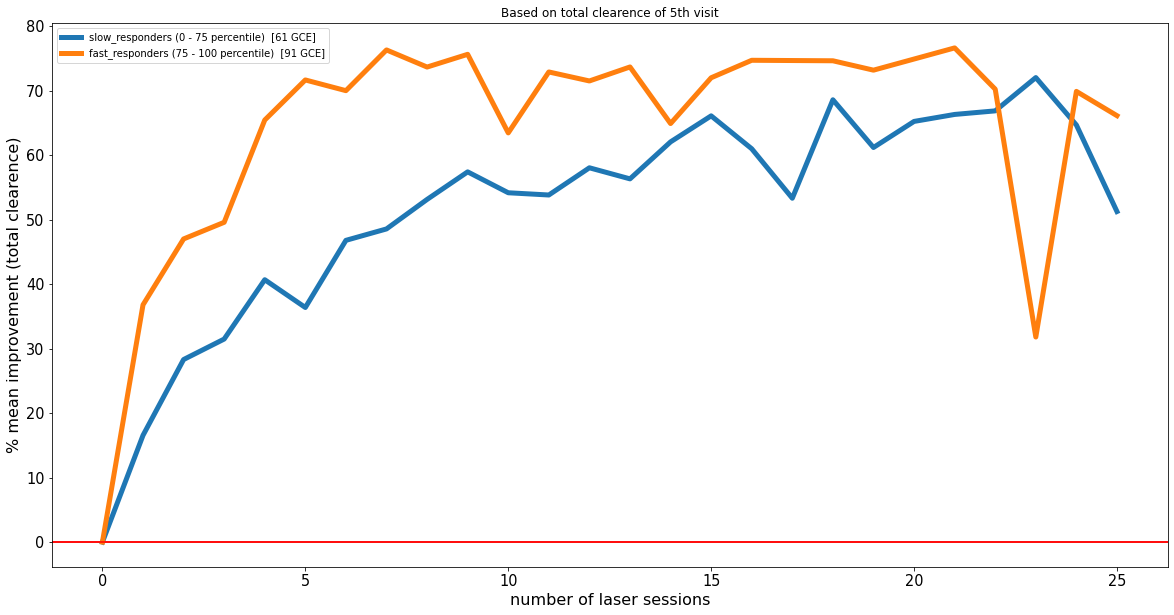

In [13]:
divide_n_plot_patients(visit_nr = 5, split_numbers = [0,75,100], split_groups = 2)